<div style ="font-family:Trebuchet MS; background-color : #f8f0fa; border-left: 5px solid #1b4332; padding: 12px; border-radius: 50px 50px;">
    <h2 style="color: #1b4332; font-size: 48px; text-align: center;"><b> Dog Bread Classification Using Transfer Learning
 </b></h2>

# Images Exploration & Analysis

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.image as mpimg
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization,Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
labels = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [3]:
labels.shape

(10222, 2)

In [4]:
sample_submission = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')

In [5]:
sample_submission.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
1            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
2            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
3            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
4            0.008333  0.008333  0.008333  ...    0.008333     0.008333   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.008333      0.008333    0.008333                0.008333   
1  0.008333      0.008333    0.008333                0.008333   
2  0.008333      0.008333    0.008333                0.008333   
3  0.008333      0.008333    0.008333                0.008333   
4  0.008333      0.008333    0.008333                0.008333   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.008333  0.008333                 0.008333   
1                     0.008333  0.008333                 0.008333   
2                     0.008333  0.008333                 0.008333   
3                     0.008333  0.008333                 0.008333   
4                     0.008333  0.008333                 0.008333   

   yorkshire_terrier  
0           0.008333  
1           0.008333  
2           0.008333  
3           0.008333  
4           0.008333  

[5 rows x 121 columns]

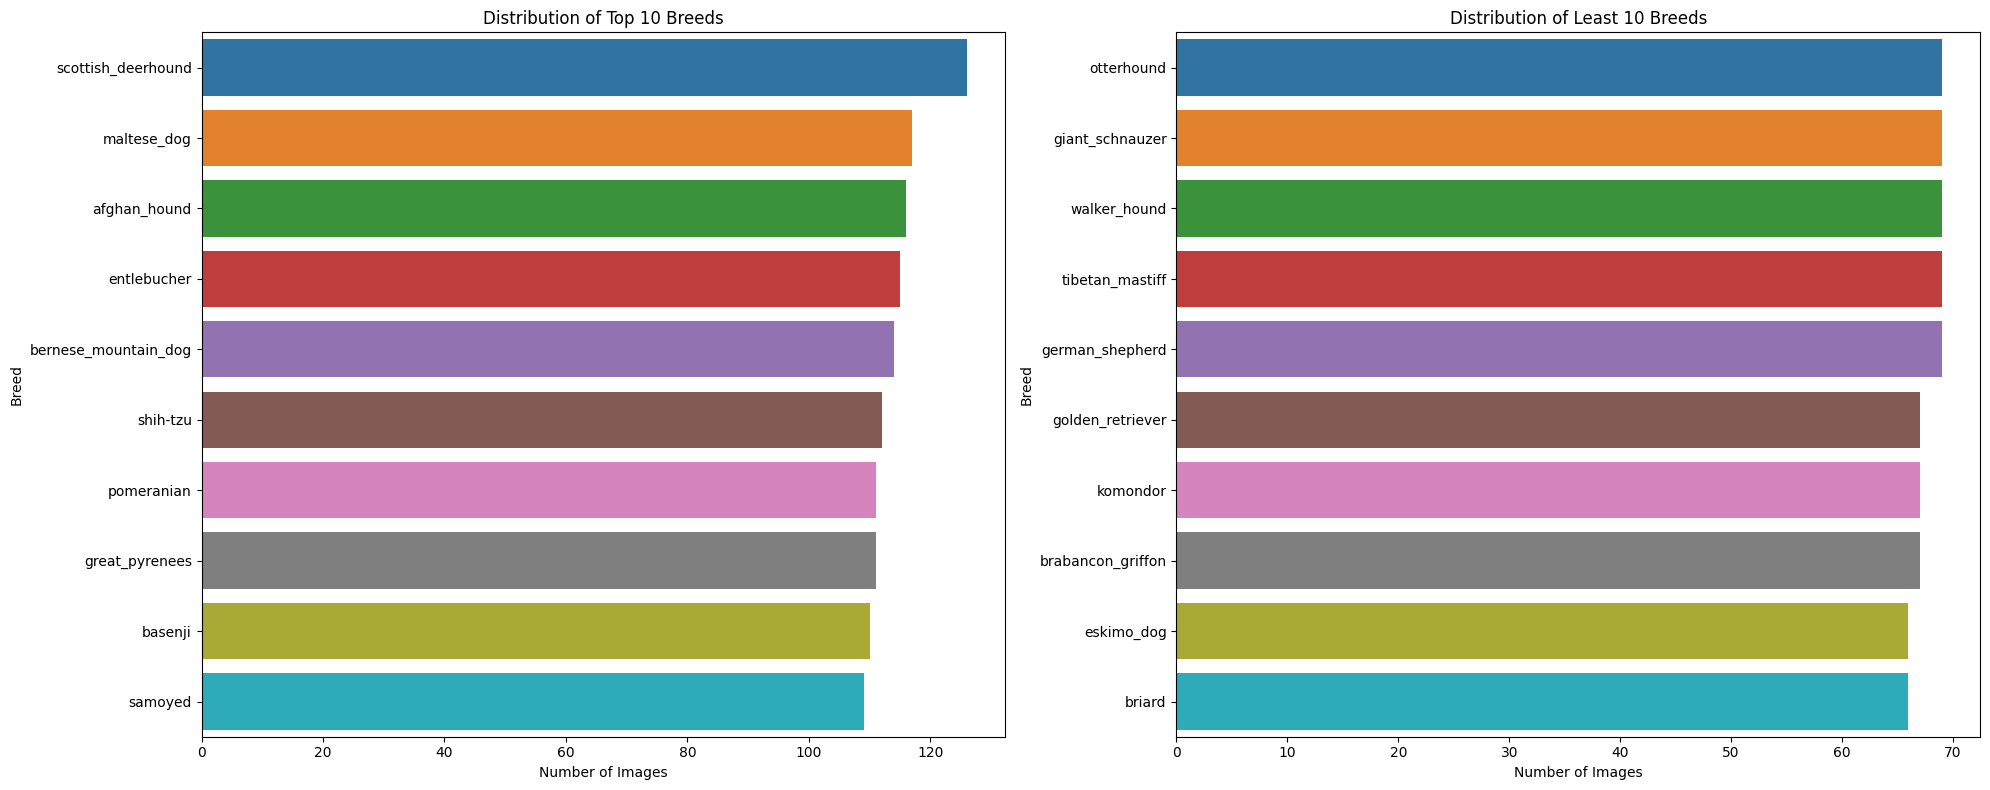

In [6]:
breed_counts = labels['breed'].value_counts()


top_10 = breed_counts.head(10)


bottom_10 = breed_counts.tail(10)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))


sns.barplot(y=top_10.index, x=top_10.values, orient='h', ax=axes[0])
axes[0].set_title('Distribution of Top 10 Breeds')
axes[0].set_xlabel('Number of Images')
axes[0].set_ylabel('Breed')

sns.barplot(y=bottom_10.index, x=bottom_10.values, orient='h', ax=axes[1])
axes[1].set_title('Distribution of Least 10 Breeds')
axes[1].set_xlabel('Number of Images')
axes[1].set_ylabel('Breed')

plt.tight_layout()
plt.show()


In [7]:
image_dir_train = '/kaggle/input/dog-breed-identification/train'
image_dir_test  = '/kaggle/input/dog-breed-identification/test'
image_files_train = [f for f in os.listdir(image_dir_train) if f.endswith('.jpg')]
image_files_test = [f for f in os.listdir(image_dir_test) if f.endswith('.jpg')]

image_files_train[:5]


['7d9c53fa846ea7e34bc3efa6830ab668.jpg',
 '04e3bb77c15c18fc1ac101d86d612f46.jpg',
 '2de892b241aeab50aad28c319eaebdbd.jpg',
 'bca88d42e4fc84b3169b13a615f5fdbf.jpg',
 '6496959bd5a27de3cb15e771ca2ae7b3.jpg']

**labels length = images_files length**

In [8]:
len(image_files_train)

10222

In [9]:
len(image_files_test)

10357

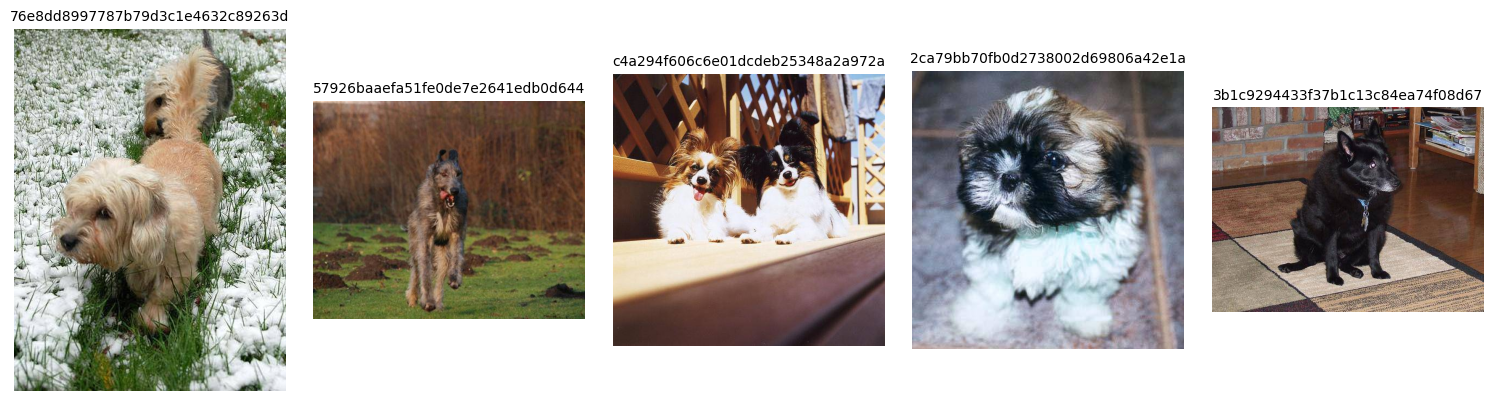

In [10]:
def display_random_images(dir,image_files,num_samples=5):

    sample_images = random.sample(image_files, num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 5))

    for i, image_file in enumerate(sample_images):
        img_path = os.path.join(dir, image_file)
        img = mpimg.imread(img_path)

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(image_file.split('.')[0], fontsize=10)

    plt.tight_layout(w_pad=2)
    plt.show()

display_random_images(image_dir_train,image_files_train,num_samples=5)


**display some of the test images**

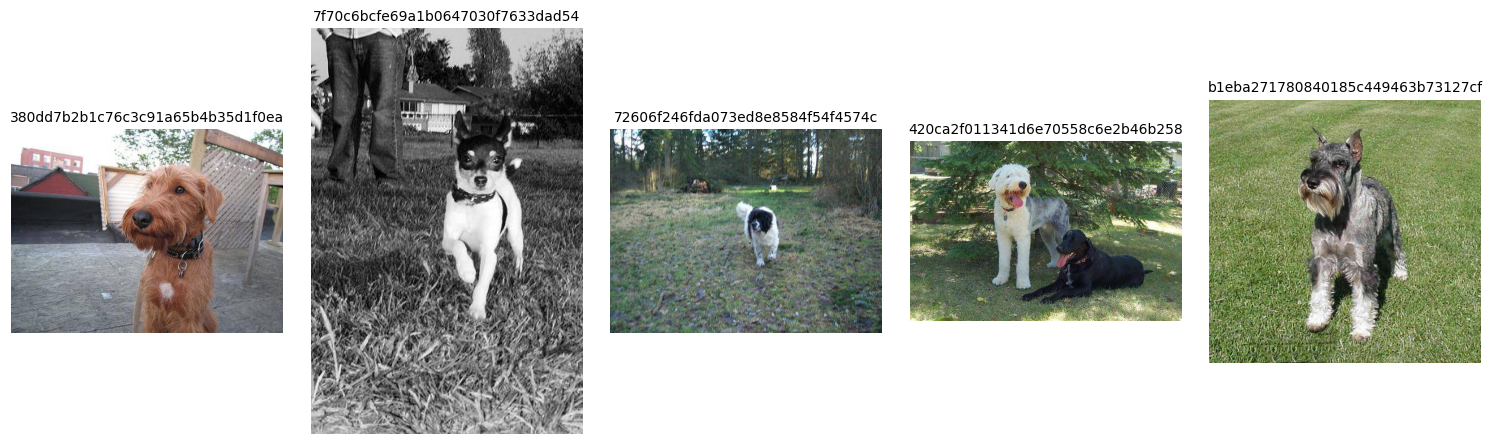

In [11]:
display_random_images(image_dir_test,image_files_test,num_samples=5)

**Label Encoder on Labels**

In [12]:
label_encoder = LabelEncoder()
labels['breed_label'] = label_encoder.fit_transform(labels['breed'])


In [13]:
max_value = labels['breed_label'].max()
min_value = labels['breed_label'].min()

print(f"Maximum value: {max_value}")
print(f"Minimum value: {min_value}")


Maximum value: 119
Minimum value: 0


In [14]:
labels.head()

id             breed  breed_label
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull           19
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo           37
2  001cdf01b096e06d78e9e5112d419397          pekinese           85
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick           15
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever           49

In [15]:
labels['breed_label'][0]

19

In [16]:
labels['breed'][0]

'boston_bull'

# Data PreProcessing

create a dictionary to map breeds to labels

In [17]:
class_names_label = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))


In [18]:
for k,v in class_names_label.items():
  print( str(k) + ': ' + v)
  if k == 5 :
    break




0: affenpinscher
1: afghan_hound
2: african_hunting_dog
3: airedale
4: american_staffordshire_terrier
5: appenzeller


In [19]:
IMAGE_SIZE = (224, 224)

def load_data(image_dir_train,  labels_df):
    """
    Load and preprocess the data:
    - Train images and their labels.
    - Test images for evaluation.
    """

    def process_images(image_dir):
        images = []
        print("Loading images from {}".format(image_dir))
        for image_file in tqdm(os.listdir(image_dir)):
            img_path = os.path.join(image_dir, image_file)

            # Open and resize the image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            images.append(image)

        return np.array(images, dtype='float32')

    # Process train images and labels
    train_images = process_images(image_dir_train)
    labels = []
    for image_file in tqdm(os.listdir(image_dir_train)):
        image_id = image_file.split('.')[0]
        label = labels_df.loc[labels_df['id'] == image_id, 'breed_label'].values[0]
        labels.append(label)
    train_labels = np.array(labels, dtype='int32')
    return train_images, train_labels



train_images, train_labels= load_data(image_dir_train,labels)
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
# print(f"Test labels shape: {test_images.shape}")

Loading images from /kaggle/input/dog-breed-identification/train


100%|██████████| 10222/10222 [00:21<00:00, 473.16it/s]

Train images shape: (10222, 224, 224, 3)
Train labels shape: (10222,)


In [20]:
train_images[0]


array([[[ 37.,  57.,  31.],
        [ 13.,  33.,   9.],
        [ 17.,  36.,  15.],
        ...,
        [ 38.,  55.,  32.],
        [ 24.,  43.,  17.],
        [ 23.,  43.,  16.]],

       [[ 46.,  66.,  41.],
        [ 32.,  51.,  29.],
        [ 35.,  54.,  34.],
        ...,
        [ 54.,  73.,  47.],
        [ 27.,  49.,  21.],
        [ 23.,  45.,  17.]],

       [[ 54.,  73.,  52.],
        [ 46.,  65.,  45.],
        [ 46.,  65.,  49.],
        ...,
        [ 61.,  84.,  55.],
        [ 32.,  57.,  24.],
        [ 27.,  53.,  20.]],

       ...,

       [[115., 160., 119.],
        [111., 156., 115.],
        [106., 151., 110.],
        ...,
        [ 96., 136., 101.],
        [100., 140., 103.],
        [107., 147., 110.]],

       [[106., 151., 110.],
        [113., 158., 117.],
        [101., 146., 105.],
        ...,
        [ 93., 133.,  98.],
        [ 94., 134.,  98.],
        [103., 143., 106.]],

       [[ 98., 143., 102.],
        [ 97., 143., 101.],
        [106., 1

In [21]:
max(train_labels),min(train_labels),len(train_labels)

(119, 0, 10222)

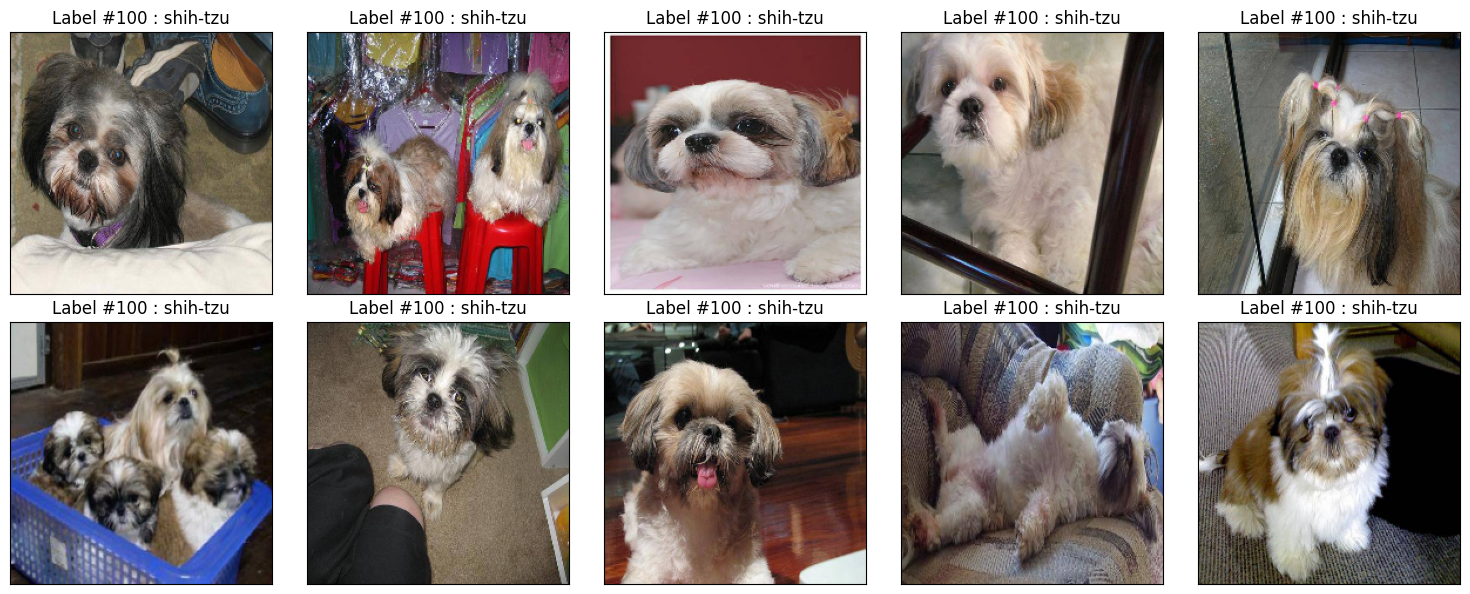

In [22]:
target_breed = "shih-tzu" 
target_label = labels[labels['breed'] == 'shih-tzu'].iloc[0, 2] 
count = 0  
max_images = 10 
num_columns = 5  # Number of columns in the grid
num_rows = max_images // num_columns + int(max_images % num_columns > 0)  # Calculate the number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 6))

for index in range(len(train_images)):
    if train_labels[index] == target_label:
        image = train_images[index]
        row = count // num_columns
        col = count % num_columns
        ax = axes[row, col]

        ax.imshow(image.astype('uint8'))  # Convert to uint8 if needed
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.set_title('Label #{} : '.format(train_labels[index]) + class_names_label[train_labels[index]])

        count += 1
        if count >= max_images:
            break
for i in range(count, num_rows * num_columns):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [23]:
labels[labels['breed'] == 'shih-tzu']

id     breed  breed_label
57     0162b3e0144fb1d1ab82fbff3ace9938  shih-tzu          100
141    035f28d8ad34afaf7c8d276d6674bf8f  shih-tzu          100
229    055429c6fb404af27ac52a08216e6cda  shih-tzu          100
262    062131c6c38a1e485091c8c3329d9638  shih-tzu          100
271    06557d54077c5265ecdcd7273c9c38ca  shih-tzu          100
...                                 ...       ...          ...
9218   e79c6a88cf8da397ee67235a04741f2d  shih-tzu          100
9348   ea829d433019aedcdeb0215c10ea905b  shih-tzu          100
9728   f4f3f707907977e9f619540a51e6d9fa  shih-tzu          100
9819   f71e0bbcb7b9d348986393612e1b6800  shih-tzu          100
10020  fb5898e240410c7d736548bf938bbc0a  shih-tzu          100

[112 rows x 3 columns]

**One Hot Encoder**

In [24]:
train_labels_one_hot = to_categorical(train_labels, num_classes=120)
train_labels_one_hot[0],train_labels[0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 13)

# Spliting Train & Validation 

In [25]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8177, 224, 224, 3)
Validation data shape: (2045, 224, 224, 3)


In [26]:
model = Sequential([
    Conv2D(32, (3, 3),input_shape = (224,224,3) , activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3),  activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),  # Dropout to prevent overfitting
    Dense(120, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# model.compile(optimizer=Adam(learning_rate=0.0001), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

# model.summary()

In [28]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Data Augmentation

In [29]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,     # Randomly flip half the images horizontally
    rotation_range=20,        # Random rotations up to 20 degrees
    width_shift_range=0.2,    # Randomly shift images horizontally by 20%
    height_shift_range=0.2,   # Randomly shift images vertically by 20%
    shear_range=0.2,          # Apply random shear transformations
    zoom_range=[0.9, 1.1],    # Slightly conservative zoom
    brightness_range=[0.8, 1.2], # Randomly change brightness
    fill_mode='nearest'       # Fill in new pixels using reflection to avoid artifacts
)


In [30]:
datagen2 = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,     # Randomly flip half the images horizontally
    zoom_range=[0.9, 1.1],    # Slightly conservative zoom
    brightness_range=[0.8, 1.2], # Randomly change brightness
    fill_mode='nearest'       # Fill in new pixels using reflection to avoid artifacts
)

In [31]:
## without data augmentation 
datagen3 = ImageDataGenerator(
    rescale=1.0/255.0,
)

In [32]:
X_val = X_val / 255.0


In [33]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)
# train_generator2 = datagen2.flow(X_train, y_train, batch_size=32)
# train_generator3 = datagen3.flow(X_train, y_train, batch_size=32)


# Show Some Augmentations

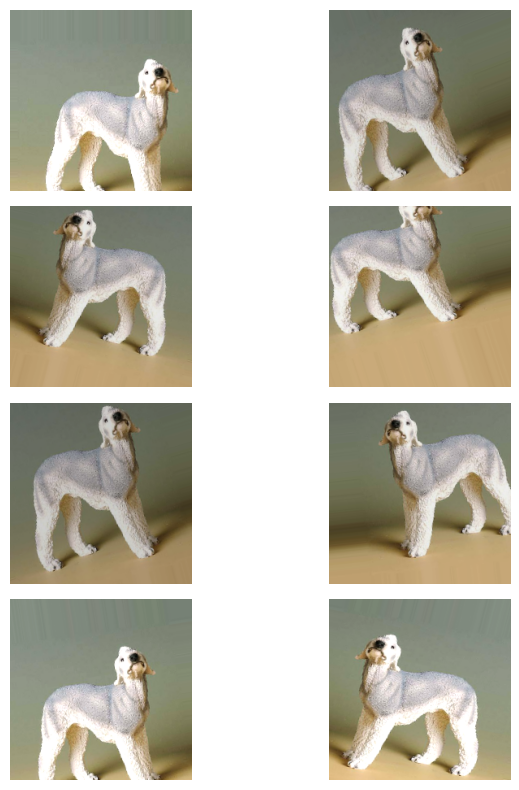

In [34]:
def display_augmented_images(datagen, image, num_images=4, grid_size=(2, 2), target_size=(150, 150)):
    """
    Displays augmented images in a grid layout.

    Parameters:
        datagen (ImageDataGenerator): The data generator with the augmentation settings.
        image (numpy array): The image to be augmented.
        num_images (int): Number of augmented images to display.
        grid_size (tuple): The size of the grid (rows, cols).
        target_size (tuple): The target size for resizing the images (height, width).
    """
    # Ensure the image has the correct shape for the generator
    img = image.reshape((1,) + image.shape)
    
    # Create the grid layout
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 8))
    axes = axes.flatten()  # Flatten the grid to make indexing easier
    
    # Generate and plot the images
    for i, batch in enumerate(datagen.flow(img, batch_size=1)):
        if i >= num_images:
            break

        # Normalize the image data to the range [0, 1] if necessary
        image_to_display = batch[0] / 255.0 if batch[0].max() > 1 else batch[0]
        
        # Remove the color channels dimension if it's grayscale
        if image_to_display.shape[-1] == 1:
            image_to_display = image_to_display.squeeze()

        # Display the image
        axes[i].imshow(image_to_display)
        axes[i].axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()


display_augmented_images(datagen, X_train[0], num_images=8, grid_size=(4, 2))

**try another combination**

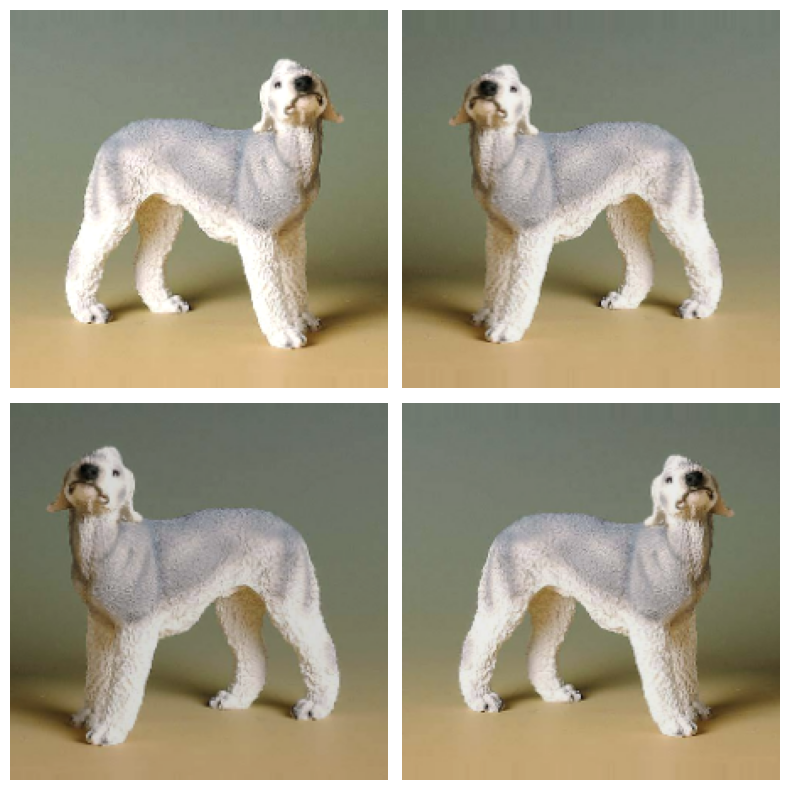

In [35]:
display_augmented_images(datagen2, X_train[0], num_images=4, grid_size=(2, 2))

In [36]:
# Plot training & validation loss values
def plot_loss(history,model) :
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

In [37]:
def plot_acc(history,model) :
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

# Transfer Learning 

**callbacks**

In [38]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr * float(tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)



In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## **InceptionV3**

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725878671.953126      74 service.cc:145] XLA service 0x7fe780007b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725878671.953188      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/255 ━━━━━━━━━━━━━━━━━━━━ 1:12:59 17s/step - accuracy: 0.0312 - loss: 5.0075

I0000 00:00:1725878679.573078      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


255/255 ━━━━━━━━━━━━━━━━━━━━ 124s 421ms/step - accuracy: 0.2413 - loss: 3.8969 - val_accuracy: 0.7707 - val_loss: 1.1304 - learning_rate: 0.0010
Epoch 2/15
  1/255 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6875 - loss: 1.3573

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6875 - loss: 1.3573 - val_accuracy: 0.7687 - val_loss: 1.1270 - learning_rate: 0.0010
Epoch 3/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 92s 349ms/step - accuracy: 0.7041 - loss: 1.2219 - val_accuracy: 0.7966 - val_loss: 0.7446 - learning_rate: 0.0010
Epoch 4/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7500 - loss: 0.9306 - val_accuracy: 0.7951 - val_loss: 0.7451 - learning_rate: 0.0010
Epoch 5/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 91s 349ms/step - accuracy: 0.7411 - loss: 0.9364 - val_accuracy: 0.8156 - val_loss: 0.6622 - learning_rate: 0.0010
Epoch 6/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7812 - loss: 0.8354 - val_accuracy: 0.8171 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 7/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 92s 350ms/step - accuracy: 0.7523 - loss: 0.8388 - val_accuracy: 0.8098 - val_loss: 0.6369 - learning_rate: 0.0010
Epoch 8/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7500 - loss: 0.7155 

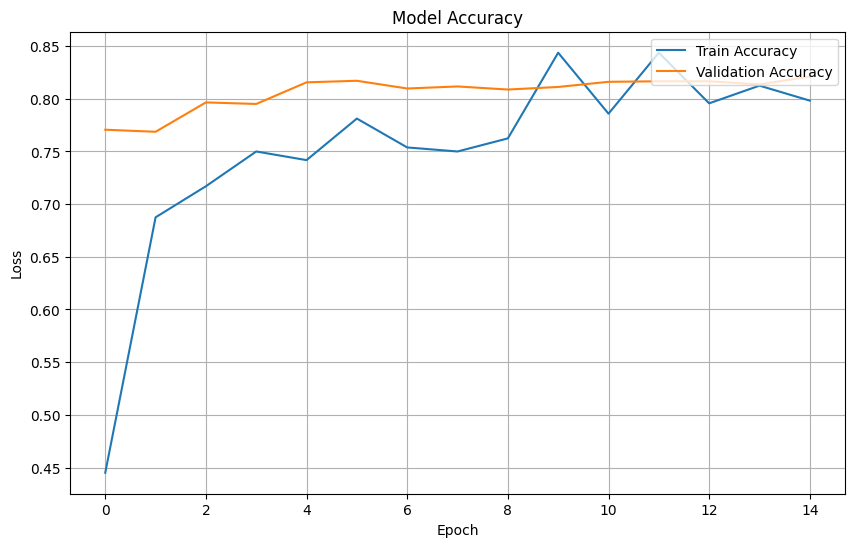

Validation Loss: 0.5930
Validation Accuracy: 0.8210


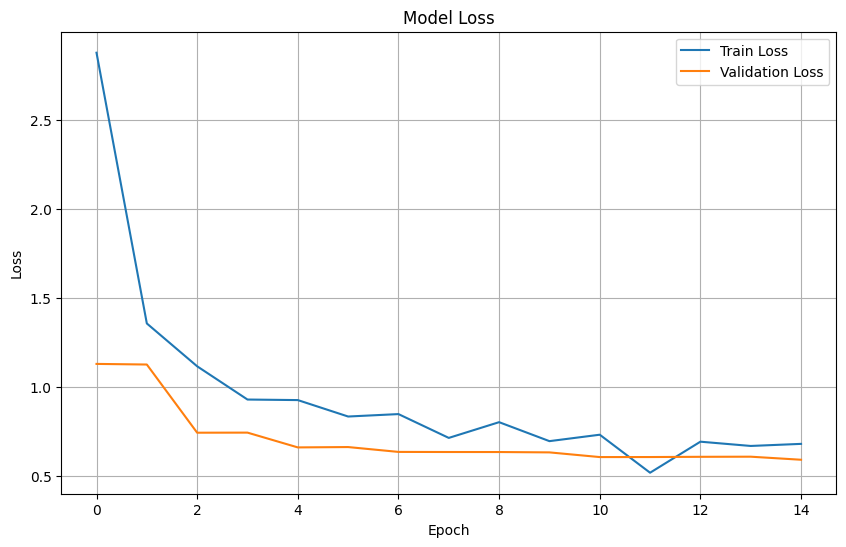

Validation Loss: 0.5930
Validation Accuracy: 0.8210


In [40]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import SGD



def train_model_with_generator(train_gen, batch_size=32, epochs=15):
    # Create a new model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    last_layer = base_model.get_layer('mixed10')
    last_output = last_layer.output
    x = GlobalAveragePooling2D()(last_output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(120, activation='softmax')(x)
    
    # Create the full model
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    sgd = SGD(
    learning_rate=0.001,  # Consider increasing this to 0.001 or 0.01 if training is slow
    momentum=0.9,
    nesterov=False,
    name='SGD'  # Correctly specify the name as a string
    )

# Compile the model with the SGD optimizer
    model.compile(
    optimizer=sgd,
    loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if your labels are integers
    metrics=['accuracy']
)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    
    steps_per_epoch = len(X_train) // batch_size  # Number of batches per epoch


    # Train the model
    history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val , y_val),
    epochs=epochs,
    callbacks=[early_stopping,lr_callback],
        )

    
    return history,model
history1,model = train_model_with_generator(train_generator)
plot_acc(history1,model)
plot_loss(history1,model)
# history2 = train_model_with_generator(train_generator2)
# plot_acc(history2,model)
# plot_loss(history2,model)
# history3 = train_model_with_generator(train_generator3)
# plot_acc(history3,model)
# plot_loss(history3,model)



In [41]:
# model.save('/kaggle/working/InceptionV3.h5')


# Evaluation 

In [42]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/inceptionv3/keras/default/1/InceptionV3.h5')

In [43]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 54, 54,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_20… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 24,023,962 (91.64 MB)

 Trainable params: 2,221,176 (8.47 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 2 (12.00 B)

In [44]:
IMAGE_SIZE = (224, 224)

def load_data(image_dir_test):
    """
    Load and preprocess the data:
    - Train images and their labels.
    - Test images for evaluation.
    """

    def process_images(image_dir):
        images = []
        print("Loading images from {}".format(image_dir))
        for image_file in tqdm(os.listdir(image_dir)):
            img_path = os.path.join(image_dir, image_file)

            # Open and resize the image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            images.append(image)

        return np.array(images, dtype='float32')

    # Process train images and labels
    test_images = process_images(image_dir_test)
    ids = []
    for image_file in tqdm(os.listdir(image_dir_test)):
        image_id = image_file.split('.')[0]
        ids.append(image_id)
    return test_images, ids


image_dir_test  = '/kaggle/input/dog-breed-identification/test'
test_images, ids = load_data(image_dir_test)

Loading images from /kaggle/input/dog-breed-identification/test


100%|██████████| 10357/10357 [00:00<00:00, 953163.06it/s]


In [45]:
print(f"Test images shape: {test_images.shape} ")

Test images shape: (10357, 224, 224, 3) 


In [46]:
len(ids)

10357

In [47]:
test_images[0]

array([[[ 83.,  86.,  92.],
        [ 94.,  95.,  99.],
        [123., 121., 124.],
        ...,
        [159., 157., 158.],
        [164., 162., 163.],
        [159., 157., 158.]],

       [[ 80.,  83.,  90.],
        [ 82.,  83.,  87.],
        [118., 116., 119.],
        ...,
        [152., 150., 151.],
        [152., 150., 151.],
        [167., 164., 165.]],

       [[ 77.,  80.,  88.],
        [ 80.,  81.,  87.],
        [120., 118., 121.],
        ...,
        [135., 133., 134.],
        [137., 136., 136.],
        [141., 139., 140.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [ 99.,  98.,  90.],
        [ 93.,  80.,  72.],
        [110.,  94.,  87.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [ 85.,  78.,  72.],
        [103.,  92.,  84.],
        [136., 123., 115.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [48]:
test_images = test_images / 255.0

In [49]:
test_images[0]

array([[[0.3254902 , 0.3372549 , 0.36078432],
        [0.36862746, 0.37254903, 0.3882353 ],
        [0.48235294, 0.4745098 , 0.4862745 ],
        ...,
        [0.62352943, 0.6156863 , 0.61960787],
        [0.6431373 , 0.63529414, 0.6392157 ],
        [0.62352943, 0.6156863 , 0.61960787]],

       [[0.3137255 , 0.3254902 , 0.3529412 ],
        [0.32156864, 0.3254902 , 0.34117648],
        [0.4627451 , 0.45490196, 0.46666667],
        ...,
        [0.59607846, 0.5882353 , 0.5921569 ],
        [0.59607846, 0.5882353 , 0.5921569 ],
        [0.654902  , 0.6431373 , 0.64705884]],

       [[0.3019608 , 0.3137255 , 0.34509805],
        [0.3137255 , 0.31764707, 0.34117648],
        [0.47058824, 0.4627451 , 0.4745098 ],
        ...,
        [0.5294118 , 0.52156866, 0.5254902 ],
        [0.5372549 , 0.53333336, 0.53333336],
        [0.5529412 , 0.54509807, 0.54901963]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

In [50]:
predictions = model.predict(test_images)

In [ ]:
len(predictions)

In [ ]:
predicted_breed = []
for i in range(len(predictions)) :
    predicted_breed.append(class_names_label[np.argmax(predictions[i])])
predicted_breed[:5]

In [ ]:
breed_names = class_names_label.values() 
breed_names


# Display Some Predictions

In [ ]:
def display_predictions(test_images,predicted_breed, num_images=5):
    """
    Displays a specified number of test images with their predicted breed labels.

    Parameters:
    - test_images (array-like): Rescaled test images, shape (num_samples, height, width, channels).
    - predictions (array-like): Predicted class indices for the test images.
    - predicted_breed (list): List mapping class indices to breed names.
    - num_images (int): Number of images to display.
    """
    plt.figure(figsize=(15, 5))  

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1) 
        image = test_images[i]
        plt.imshow(image)
        plt.axis('off') 
        breed_name = predicted_breed[i]
        plt.title(breed_name, fontsize=12)
    
    plt.tight_layout()
    plt.show()
display_predictions(test_images,  predicted_breed, num_images=5)

# Submission 

In [ ]:
# def create_submission_csv(image_ids, predictions, breed_names, output_file='submission.csv'):
#     """
#     Creates a CSV file for submission with columns: id, breed1, breed2, ..., breedN.

#     Parameters:
#     - image_ids (list): List of image IDs.
#     - predictions (array-like): 2D array of predicted probabilities, shape (num_samples, num_breeds).
#     - breed_names (list): List of breed names corresponding to the columns.
#     - output_file (str): Name of the output CSV file.
#     """
#     # Create a DataFrame with image_ids as the 'id' column
#     df = pd.DataFrame(predictions, columns=breed_names)
#     df.insert(0, 'id', image_ids)  # Insert the 'id' column at the beginning
#     df.to_csv(output_file, index=False)
#     print(f"CSV file saved as {output_file}")
# create_submission_csv(ids, predictions, breed_names, output_file='submission.csv')